# EfficientNetB2 Model 1b
## Preprocessing method: image_dataset_from_directory()
## Image size: (260, 260) 
## Images: Grayscale
## Frozen pretrained layers
## No image transformation

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [3]:
image_size = (260, 260)
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_training,
                                                               color_mode = "grayscale",
                                                               seed=1993,
                                                               image_size = image_size)

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                              seed=1993,
                                                              color_mode = "grayscale",
                                                              image_size = image_size)

one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.


In [4]:
plt.figure(figsize=(10, 10))
class_names = val_ds.class_names
for images, labels in val_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
valid_label = np.concatenate([y for x, y in val_ds], axis=0)

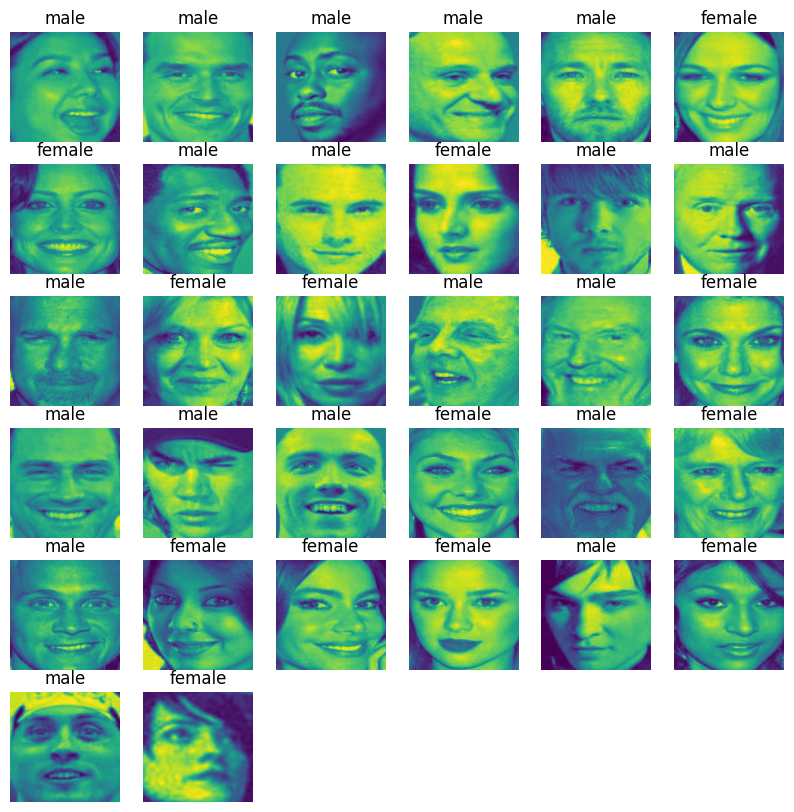

In [6]:
plt.show()

In [7]:
ENB2_model = keras.applications.EfficientNetB2(weights='imagenet', include_top=True)
ENB2_model.trainable = False

# Model layers
input_tensor = tf.keras.layers.Input(shape=(260, 260, 1))
x = keras.layers.Conv2D(3,(3,3),padding='same')(input_tensor)
x = ENB2_model(x)
out = keras.layers.Dense(2, activation='softmax')(x)

# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs=1000     # Set epochs

# Generate model
model = keras.Model(inputs = input_tensor, outputs = out)
model.compile(optimizer=keras.optimizers.Adam(1e-2),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 260, 260, 3)       30        
                                                                 
 efficientnetb2 (Functional)  (None, 1000)             9177569   
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 9,179,601
Trainable params: 2,032
Non-trainable params: 9,177,569
_________________________________________________________________


In [9]:
mod_fit = model.fit(one_hot_encoded_train_ds, 
                      epochs=epochs, 
                      validation_data=one_hot_encoded_val_ds,
                      callbacks=[callback])

Epoch 1/1000
1470/1470 [==============================] - 172s 117ms/step - loss: 0.4067 - accuracy: 0.8588 - val_loss: 0.2928 - val_accuracy: 0.8960
Epoch 2/1000
1470/1470 [==============================] - 171s 116ms/step - loss: 0.3265 - accuracy: 0.8742 - val_loss: 0.2764 - val_accuracy: 0.8997
Epoch 3/1000
1470/1470 [==============================] - 170s 116ms/step - loss: 0.3131 - accuracy: 0.8788 - val_loss: 0.2583 - val_accuracy: 0.9051
Epoch 4/1000
1470/1470 [==============================] - 170s 116ms/step - loss: 0.3078 - accuracy: 0.8803 - val_loss: 0.2564 - val_accuracy: 0.9063
Epoch 5/1000
1470/1470 [==============================] - 170s 116ms/step - loss: 0.3078 - accuracy: 0.8813 - val_loss: 0.2610 - val_accuracy: 0.9047
Epoch 6/1000
1470/1470 [==============================] - 171s 116ms/step - loss: 0.3010 - accuracy: 0.8827 - val_loss: 0.2655 - val_accuracy: 0.9010
Epoch 7/1000
1470/1470 [==============================] - 170s 116ms/step - loss: 0.2979 - accuracy:

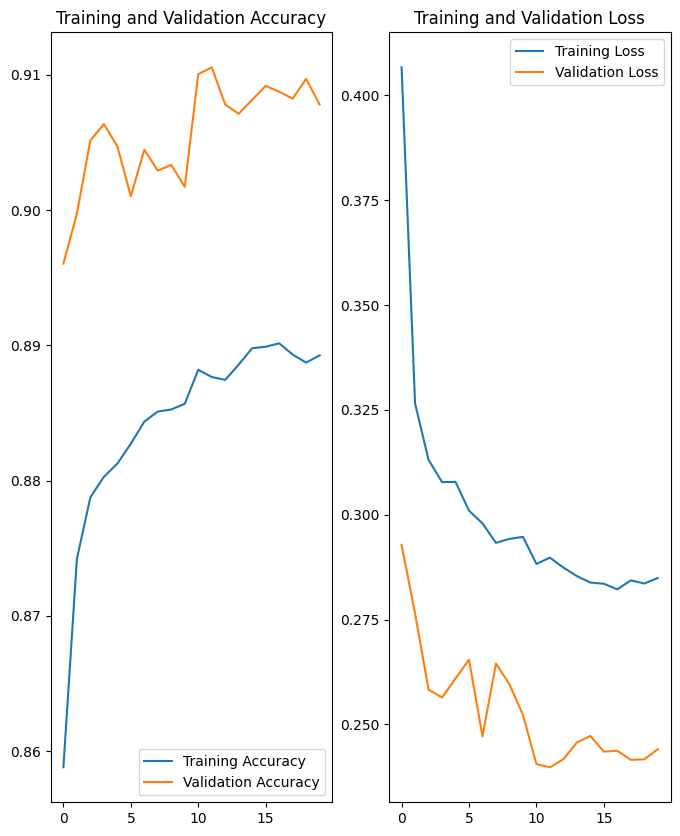

In [13]:
acc= mod_fit.history['accuracy']
val_acc = mod_fit.history['val_accuracy']

loss = mod_fit.history['loss']
val_loss = mod_fit.history['val_loss']

epochs_range = range(0, 20)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
#model.save('GC weights/Frozen/mod3b-gs')
model.save_weights('GC weights/Frozen/mod3b-gs/mod3b_gs_frozen.h5')